# Traditional Time Series Models for Prediction

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
import matplotlib.pyplot as plt
from hts import HTSRegressor
from tqdm import tqdm
import pickle
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from catboost import CatBoostRegressor

In [2]:
df = pd.read_csv("../data/local_data/merged_cleaned_data.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2715771 entries, 0 to 2715770
Data columns (total 11 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   Census Section           int64  
 1   District                 int64  
 2   Date                     object 
 3   Use                      object 
 4   Number of Meters         int64  
 5   Accumulated Consumption  int64  
 6   Max Temperature          float64
 7   Min Temperature          float64
 8   Precipitation            float64
 9   Tourist Accommodations   float64
 10  Hotel Overnight Stays    int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 227.9+ MB


In [4]:
# Assuming we don't wanna work by differenciating the use column
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Aggregate data by Census Section and Date. We ignore the district info since it is not relevant at all
# Another alternative would be to do the grouping by District and Date, but thus leaving to less datapoints
df_census = df.groupby(['Census Section', 'Date']).agg({
    'Accumulated Consumption': 'sum',
    'Number of Meters': 'sum',
    'Max Temperature': 'mean',
    'Min Temperature': 'mean',
    'Precipitation': 'mean',
    'Tourist Accommodations': 'mean',
    'Hotel Overnight Stays': 'mean'
}).reset_index()

df_hierarchy = df.groupby(['District', 'Census Section', 'Date']).agg({
    'Accumulated Consumption': 'sum',
    'Number of Meters': 'sum',
    'Max Temperature': 'mean',
    'Min Temperature': 'mean',
    'Precipitation': 'mean',
    'Tourist Accommodations': 'mean',
    'Hotel Overnight Stays': 'mean'
}).reset_index()

In [5]:
df_census.head()

,Census Section,Date,Accumulated Consumption,Number of Meters,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays
0,801901001,2021-01-01,153414,388,7.55,4.30,5.65,1775.0,4411.0
1,801901001,2021-01-02,166201,388,8.55,1.55,0.00,4646.0,11547.0
2,801901001,2021-01-03,129309,388,9.55,0.85,0.00,3151.0,7833.0
3,801901001,2021-01-04,141909,387,10.10,0.65,0.00,4337.0,10778.0
4,801901001,2021-01-05,137782,387,9.40,0.65,0.00,4580.0,11382.0


In [6]:
df_hierarchy.head()

,District,Census Section,Date,Accumulated Consumption,Number of Meters,Max Temperature,Min Temperature,Precipitation,Tourist Accommodations,Hotel Overnight Stays
0,1,801901001,2021-01-01,153414,388,7.55,4.30,5.65,1775.0,4411.0
1,1,801901001,2021-01-02,166201,388,8.55,1.55,0.00,4646.0,11547.0
2,1,801901001,2021-01-03,129309,388,9.55,0.85,0.00,3151.0,7833.0
3,1,801901001,2021-01-04,141909,387,10.10,0.65,0.00,4337.0,10778.0
4,1,801901001,2021-01-05,137782,387,9.40,0.65,0.00,4580.0,11382.0


## SARIMA

Keep in mind that the Seasonal ARIMA is a univariate model, meaning that it cal only deal with 1 single time series; in this case, it would be the number of accumulated consumpltion. However, the model is indeed about more than 1 time series, take for instance tourist accommodations, hotel overnight stays, census section...

Moreover, different models should be trained for each census section since each census might have a different seasonality trend; the stationarity of a time series can vary significantly from one census section to another, due to different intervention effects, economic activities, or infrastructural changes over time.

Glossary: 

* Augmented Dickey-Fuller Test (ADF): Used to test for stationarity in a time series, which is a critical assumption in many time series forecasting models, including ARIMA and SARIMA models. A time series is considered stationary if its statistical properties such as mean, variance, and autocorrelation are constant over time. The test checks for the presence of a unit root in a time series model. A unit root situation implies that the time series is non-stationary, meaning it has properties that can vary over time. The ADF test addresses this by testing whether the time series can be explained without the need to account for an underlying trend or seasonality.

* H0 Null Hypothesis: In this particular case, the null hypothesis states that there is a unit root; which is the same as saying that there is no stationality. Our need is to prove that the IS stationality to reason the use of SARIMA. 

* ADF Statistic: This is the value used to reject or fail to reject the null hypothesis. The more negative the ADF statistic, the stronger the evidence against the null hypothesis that there is a unit root (i.e., the time series is non-stationary).


Understanding the plot in seasonal_decompose:

* Original Series: shown at the top and represents the actual data of accumulated consumption over time.

* Trend Component: smooths out the series to show the underlying trend in the data. If there are spikes, they could represent systematic changes in consumption that occur at specific times; if not, the accumulated consumption does not exhibit a strong or consistent upward or downward trend over the period observed.

* Seasonal Component: shows regular patterns that repeat over a fixed period. 

* Residual Component: portion of the data that is not explained by the trend or seasonal components. Ideally, we want the residuals to appear as random noise, indicating that the model has captured all the systematic information in the data.

Understanding the results' summary:

* Log likelihood: measure of the likelihood that the model, given its parameters, produced the observed data. A higher log likelihood means that the model’s parameters are more likely to have generated the observed data.

* Akaike Information Criterion (AIC): estimate of the information lost when a given model is used to represent the process that generates the data. A lower AIC value indicates a model that better explains the variability in the data with fewer parameters. It balances model complexity and goodness of fit: lower values mean a model is effectively capturing the pattern with an optimal number of parameters.

* Bayesian Information Criterion (BIC): Similar to AIC, lower is better.

* p-values of Coefficients: each term (AR, MA, seasonal parts) has an associated p-value which tests the null hypothesis that the coefficient is zero (no effect). We want a p-value less than 0.05, which would suggest that the coefficient is statistically significant.

* Ljung-Box Test (Q): Tests for lack of fit or autocorrelation in the residuals of the model. A significant test (low p-value) indicates autocorrelation remains in the residuals, suggesting poor model fit. We want high p-values (usually greater than 0.05), indicating no autocorrelation.

* Jarque-Bera Test (JB): Tests whether the residuals have a normal distribution in terms of skewness and kurtosis. Deviations from normality can invalidate statistical tests that assume normality. We want high p-value indicating that the residuals are normally distributed. 

* Heteroskedasticity (H): Tests if the variance of the residuals is constant across the data. Non-constant variance can suggest that certain model assumptions are violated. High p-value indicates constant variance; low p-values indicate potential issues with model assumptions.

* Projg (Norm of the Projected Gradient): how close the gradient (or steepest descent) is to zero, indicating no further improvements are possible in minimization. Closer to zero is better, indicating convergence in optimization.

Understanding the diagnostic plot:

* Standardized Residual Plot: displays the standardized residuals of the model over time. We look for no obvious patterns or trends in this plot, which would suggest that the model has appropriately accounted for any seasonality, trend, or other structure in the data.

* Histogram plus Estimated Density: histogram of the standardized residuals, along with a Kernel Density Estimate (KDE) and the normal density curve. The closer the shape of the histogram and KDE is to the green normal line (N(0,1)), the more normal the distribution, which is desired.

* Normal Q-Q Plot: quantiles of residuals against the theoretical quantiles from a normal distribution. A perfectly normal distribution would align closely with the red line.

* Correlogram (or ACF plot): the correlation of the series with itself at different lags. Ideal output would have all bars within the blue threshold lines, suggesting that there is no significant autocorrelation at any lag. This would mean the model has successfully captured the time-dependent structure in the data.

### Case Analysis Census Section \#801901001

ADF Statistic: -1.366332
p-value: 0.598306


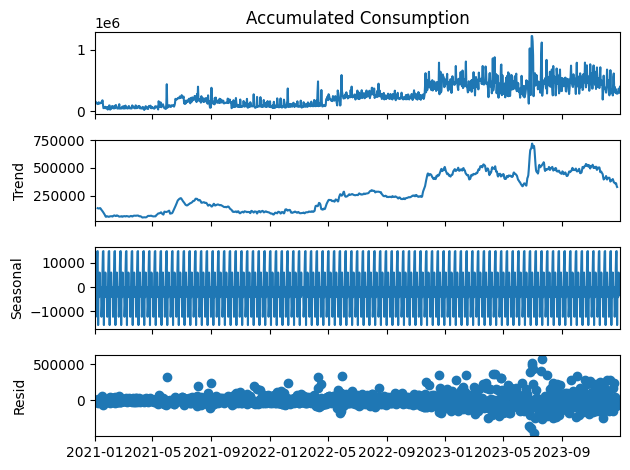

/Users/yuyi/Desktop/ProjectManagement/venv2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/yuyi/Desktop/ProjectManagement/venv2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.30267D+01    |proj g|=  6.81207D-02


 This problem is unconstrained.



At iterate    5    f=  1.29565D+01    |proj g|=  1.11582D-02

At iterate   10    f=  1.29547D+01    |proj g|=  3.64204D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     17      1     0     0   4.441D-06   1.295D+01
  F =   12.954706692930483     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
                                     SARIMAX Results                                      
Dep. Variable:            Accumulated Consumption   No. Observations:                 1094
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood              -14172.449
Date:                     

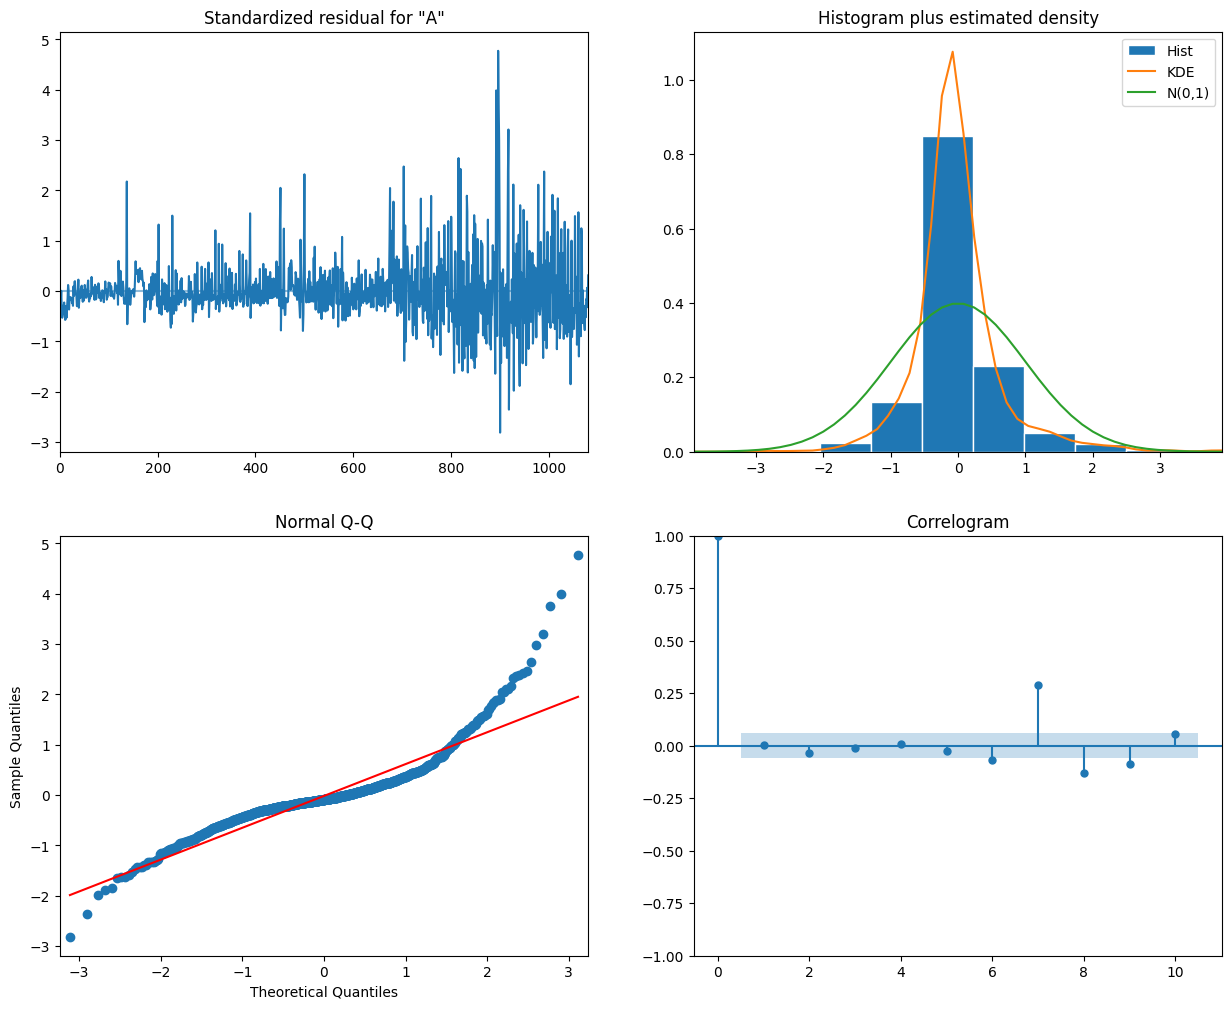

In [7]:
df_test = df_census[df_census["Census Section"]==801901001]

# Use time based indexing
df_test.set_index('Date', inplace=True)
# Removing an detected outlier
df_test = df_test.drop(pd.Timestamp('2022-03-09'))

# Check stationarity
result = adfuller(df_test['Accumulated Consumption'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

# # TO IGNORE
# Technique used to make the time series stationary
if result[1] > 0.05:  # Data is not stationary
    df_test['Differenced Consumption'] = df_test['Accumulated Consumption'].diff().dropna()
    # raise Warning("There is no seasonality in the data")

# Seasonal Decompose
decompose_result = seasonal_decompose(df_test['Accumulated Consumption'], model='additive', period=12)
decompose_result.plot()
plt.show()

# SARIMA Model
# TODO: Explore more withthe order and the seasonal order
model = SARIMAX(df_test['Accumulated Consumption'], order=(1,1,1), seasonal_order=(1,1,1,12))
results = model.fit()

# Summarize the results
print(results.summary())

# Plot diagnostics
results.plot_diagnostics(figsize=(15, 12))
plt.show()

### Generalized Function

In [8]:
def sarima_census_section(census_section, df=df_census, outlier_date=None, seasonal_decomposition=False, diagnostic_plots=False):
    df_test = df[df["Census Section"] == census_section]
    df_test.set_index('Date', inplace=True)
    
    if outlier_date: df_test = df_test.drop(pd.Timestamp(outlier_date))
    
    # Check stationarity using the Augmented Dickey-Fuller test
    result = adfuller(df_test['Accumulated Consumption'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    
    if result[1] > 0.05:
        print(f"There is no seasonality in the data for census {census_section}")
        df_test['Differenced Consumption'] = df_test['Accumulated Consumption'].diff().dropna()

    if seasonal_decomposition:
        decompose_result = seasonal_decompose(df_test['Accumulated Consumption'], model='additive', period=12)
        decompose_result.plot()
        plt.show()

    model = SARIMAX(df_test['Accumulated Consumption'], order=(1,1,1), seasonal_order=(1,1,1,12))
    results = model.fit()

    print(results.summary())

    if diagnostic_plots:
        results.plot_diagnostics(figsize=(15, 12))
        plt.show()

ADF Statistic: -5.055381
p-value: 0.000017


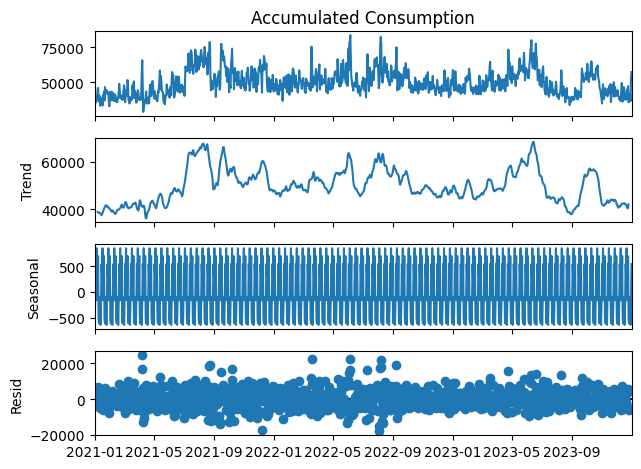

/Users/yuyi/Desktop/ProjectManagement/venv2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/yuyi/Desktop/ProjectManagement/venv2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00925D+01    |proj g|=  6.60912D-02


 This problem is unconstrained.



At iterate    5    f=  1.00518D+01    |proj g|=  8.08200D-03

At iterate   10    f=  1.00498D+01    |proj g|=  2.03665D-04

At iterate   15    f=  1.00498D+01    |proj g|=  6.44857D-05

At iterate   20    f=  1.00498D+01    |proj g|=  1.02017D-03

At iterate   25    f=  1.00483D+01    |proj g|=  1.52577D-02

At iterate   30    f=  9.95982D+00    |proj g|=  1.41756D-01

At iterate   35    f=  9.93372D+00    |proj g|=  8.90864D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     41      1     0     0   9.825D-06   9.934D+00
  F =   9.9337152684611745     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

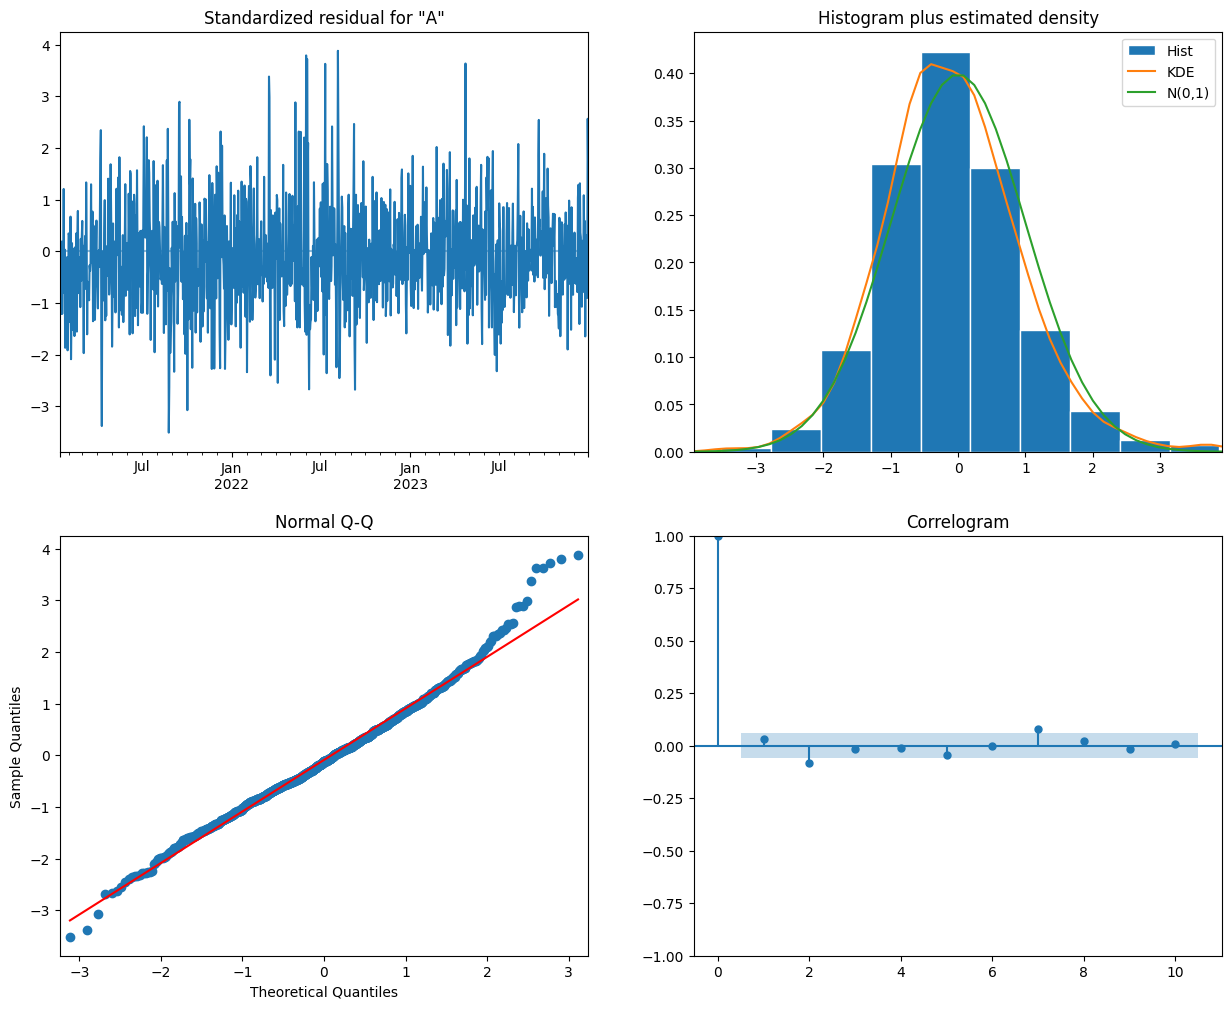

In [9]:
# Example having a better prediction but yet insufficient
sarima_census_section(801901002, seasonal_decomposition= True, diagnostic_plots=True)

## Vector Autoregression (VAR)

### Case Analysis Census Section \# 801901002

In [10]:
census_section = 801901002
df_test = df_census[df_census["Census Section"] == census_section]
var_columns = ['Accumulated Consumption', 'Tourist Accommodations', 'Max Temperature', 'Precipitation']
df_test = df_test[var_columns]

In [11]:
# Ensure stationarity
def check_stationarity(series, maxlag=None, regression='c', autolag='AIC'):
    result = adfuller(series, maxlag=maxlag, regression=regression, autolag=autolag)
    print(f'    ADF Statistic: {result[0]}')
    print(f'    p-value: {result[1]}')
    if result[1] > 0.05:
        print("     -> NOT stationary")
        return False
    else:
        print("     -> stationary")
        return True

In [12]:
# If many series are not stationary, consider applying transformations like differencing or detrending to the entire dataset or increasing the sample size for more robust testing.
for column in tqdm(df_test.columns, desc="Testing stationarity"):
    print(f"Testing stationarity for {column}:")
    if not check_stationarity(df_test[column]):
        df_test[column] = df_test[column].diff().dropna()  # Differencing non-stationary series

Testing stationarity: 100%|██████████| 4/4 [00:00<00:00, 25.41it/s]

Testing stationarity for Accumulated Consumption:
    ADF Statistic: -5.0553808593544325
    p-value: 1.7223616995187117e-05
     -> stationary
Testing stationarity for Tourist Accommodations:
    ADF Statistic: -2.053299944356877
    p-value: 0.26370251507161196
     -> NOT stationary
Testing stationarity for Max Temperature:
    ADF Statistic: -2.7108983606596166
    p-value: 0.07217128891048494
     -> NOT stationary
Testing stationarity for Precipitation:
    ADF Statistic: -21.306670560784784
    p-value: 0.0
     -> stationary


In [13]:
# model = VAR(df_test.dropna())
# var_test_model = model.fit(ic='aic')
# print(var_test_model.summary())

# # Save model to avoid repetitive fitting
# if not os.path.exists('../models'): os.makedirs('../models')
# with open(f'../models/var_model_{census_section}.pkl', 'wb') as f: pickle.dump(var_test_model, f)

In [14]:
with open('../models/var_model_801901002.pkl', 'rb') as f:
    var_test_model = pickle.load(f)

In [15]:
# Forecasting
forecast_steps = 5
forecast = var_test_model.forecast(df_test.values[-var_test_model.k_ar:], steps=forecast_steps)
# df_census['Date'] = pd.to_datetime(df_census['Date'])
df_census.set_index('Date', inplace=True)
date_index = pd.date_range(start=df_census.index[-1] + pd.Timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df = pd.DataFrame(forecast, index=date_index, columns=df_test.columns)
print(forecast_df[['Accumulated Consumption', 'Tourist Accommodations']])

            Accumulated Consumption  Tourist Accommodations
2024-01-01             53134.052492           -11485.439147
2024-01-02             51527.345600              978.719990
2024-01-03             47982.150819             5998.603429
2024-01-04             45907.924834             1298.908393
2024-01-05             46528.680595             2402.979651


### Generalized Function

Limitations: 

* Depending on how the model has been formulated, it is predicting negative values on accumulated consumption; which in fact reveals that the model should be finetuned in some way or that it has to be formulated with some non negative constraints.

* The model can only take entries that are all time series, that is, all the variables should be time series.

* The model can be only trained with numerical values, hence it is not possible to put in the census section or the district as a feature. Moreover, it does not work well making encodings (such as dummy variables) to convert those categorical fields into booleans because they can only work when the date entry apprears only once in the set. Hence, a model for each census section should be trained separately based on their own historical data. However, it is feasible to adjust the granularity of these, either by working with districts or whatever division there can be. For instance, doing clustering and train a model for prediction for each cluster.

* Related to the previous point, the model works only with time-series data rather than handling data that is both cross-sectional and time-series.

In [16]:
class CensusSectionVAR(VAR):
    def __init__(self, df, census_section, var_columns, model_save_path='../models', verbose=False):
        """
        Initialize the CensusSectionVAR object.

        :param df: pd.DataFrame, the dataset containing census data
        :param census_section: int or str, the census section to filter on
        :param var_columns: list, the columns to use for the VAR model
        :param model_save_path: str, the directory to save the model
        :param verbose: bool, whether to print verbose output
        """
        self.df = df
        self.census_section = census_section
        self.var_columns = var_columns
        self.model_save_path = model_save_path
        self.verbose = verbose
        self.var_model = None

        # Filter data for the given census section and relevant columns
        self.df_test = self.df[self.df["Census Section"] == self.census_section][self.var_columns]
        if not isinstance(self.df_test.index, pd.DatetimeIndex):
            raise ValueError("The DataFrame index must be a DatetimeIndex.")

    def _check_stationarity(self, series, name_column=None, maxlag=None, regression='c', autolag='AIC'):
        """
        Check the stationarity of a time series using the Augmented Dickey-Fuller test.
        """
        result = adfuller(series, maxlag=maxlag, regression=regression, autolag=autolag)
        if self.verbose:
            print(f'{name_column} ADF Statistic: {result[0]}')
            print(f'{name_column} p-value: {result[1]}')
        if result[1] > 0.05:
            if self.verbose:
                print(f"-> {name_column} is NOT stationary")
            return False
        else:
            if self.verbose:
                print(f"-> {name_column} is stationary")
            return True

    def fit_model(self, ic='aic', maxlag=None, regression='c', autolag='AIC', save_model=True):
        """
        Fit the VAR model to the data.

        :param ic: str, the information criterion to use for lag selection
        :param maxlag: int or None, the maximum lag to consider
        :param regression: str, the regression type for ADF test
        :param autolag: str, the method to use for ADF lag selection
        :param save_model: bool, whether to save the fitted model
        :return: VAR model and its summary
        """
        # Ensure all columns are stationary
        for column in self.df_test.columns:
            if not self._check_stationarity(self.df_test[column], name_column=column, maxlag=maxlag, regression=regression, autolag=autolag):
                self.df_test[column] = self.df_test[column].diff().dropna()

        # Fit the VAR model
        model = VAR(self.df_test.dropna())
        self.var_model = model.fit(ic=ic)
        if self.verbose:
            print(self.var_model.summary())

        # Save the model
        if save_model:
            os.makedirs(self.model_save_path, exist_ok=True)
            model_file = os.path.join(self.model_save_path, f'var_model_{self.census_section}.pkl')
            with open(model_file, 'wb') as f:
                pickle.dump(self.var_model, f)
            if self.verbose:
                print(f"Model saved to {model_file}")

        return self.var_model

    def print_summary(self):
        if self.var_model is None:
            raise ValueError("No model is loaded or trained. Train a model or load one first.")
        print(self.var_model.summary())

    def forecast(self, forecast_steps, columns_to_forecast):
        """
        Forecast future values using the trained VAR model.

        :param forecast_steps: int, number of steps to forecast
        :param columns_to_forecast: list, columns to include in the forecast output
        :return: pd.DataFrame, forecasted values with date index
        """
        if self.var_model is None:
            raise ValueError("VAR model has not been trained. Call fit_model() first.")

        # Prepare the last values for forecasting
        last_values = self.df_test.values[-self.var_model.k_ar:]
        forecast = self.var_model.forecast(last_values, steps=forecast_steps)

        # Create a date range for the forecast
        forecast_dates = pd.date_range(start=self.df_test.index[-1] + pd.Timedelta(days=1),
                                       periods=forecast_steps,
                                       freq='D')

        # Create a DataFrame for the forecast
        forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=self.df_test.columns)
        return forecast_df[columns_to_forecast]
    
    @classmethod
    def load_model(cls, file_path, df, census_section, var_columns, model_save_path='../models', verbose=False):
        """
        Load a saved VAR model from a file.

        :param file_path: str, the path to the saved model file
        :param df: pd.DataFrame, the dataset for context (required for forecasting)
        :param census_section: int or str, the census section for context
        :param var_columns: list, the columns used in the VAR model
        :param model_save_path: str, directory for saving future models (if re-saving is needed)
        :param verbose: bool, whether to print verbose output
        :return: CensusSectionVAR object with loaded model
        """
        if not os.path.exists(file_path): raise FileNotFoundError(f"Model file not found at {file_path}")

        with open(file_path, 'rb') as f:
            var_model = pickle.load(f)
        
        # Initialize the object with context data
        obj = cls(df=df, census_section=census_section, var_columns=var_columns, model_save_path=model_save_path, verbose=verbose)
        obj.var_model = var_model

        if verbose: print(f"Model loaded from {file_path}")
        
        return obj

In [17]:
# # Load model example
# loaded_instance = CensusSectionVAR.load_model(
#     file_path='../models/var_model_801901003.pkl',
#     df=df_census,
#     census_section=801901003,
#     var_columns=['Accumulated Consumption', 'Tourist Accommodations', 'Max Temperature', 'Precipitation'],
#     verbose=True
# )

In [18]:
# Example Usage
var_model = CensusSectionVAR(
    df=df_census,
    census_section=801901003,
    var_columns=['Accumulated Consumption', 'Tourist Accommodations', 'Max Temperature', 'Precipitation'],
    verbose=True
)

trained_model = var_model.fit_model(ic='fpe', save_model=True)

forecast_df = var_model.forecast(forecast_steps=5, columns_to_forecast=['Accumulated Consumption', 'Tourist Accommodations'])

print(forecast_df)

Accumulated Consumption ADF Statistic: -1.8233743811642842
Accumulated Consumption p-value: 0.3689202544430651
-> Accumulated Consumption is NOT stationary
Tourist Accommodations ADF Statistic: -2.053299944356877
Tourist Accommodations p-value: 0.26370251507161196
-> Tourist Accommodations is NOT stationary
Max Temperature ADF Statistic: -2.7108983606596166
Max Temperature p-value: 0.07217128891048494
-> Max Temperature is NOT stationary
Precipitation ADF Statistic: -21.306670560784784
Precipitation p-value: 0.0
-> Precipitation is stationary
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sat, 23, Nov, 2024
Time:                     00:32:24
--------------------------------------------------------------------
No. of Equations:         4.00000    BIC:                    38.6051
Nobs:                     1080.00    HQIC:                   37.9512
Log likelihood:          -26180.3    FPE:                2.03765e+16


/Users/yuyi/Desktop/ProjectManagement/venv2/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


## Hierarchical Time Series Modeling

Powerful approach when data naturally forms a hierarchy; allows to forecast at various levels of aggregation, ensuring that forecasts at lower levels aggregate up consistently to higher levels, which can enhance the coherence and accuracy across forecasts.

For more an example of implementation go to: https://www.kaggle.com/code/konradb/ts-8-hierarchical-time-series

In [19]:
df = pd.read_csv("../data/local_data/merged_cleaned_data.csv")
df['Date'] = pd.to_datetime(df['Date'])

In [20]:
# Create nodes to define Hierarchy
districts = df['District'].unique()
nodes = {
    'total': [f'District_{d}' for d in districts],
}
for district in districts:
    census_sections = df[df['District'] == district]['Census Section'].unique()
    nodes[f'District_{district}'] = [f'District_{district}_CensusSection_{cs}' for cs in census_sections]

# Prepare DataFrame for input
# Group by date, district, and census section, then pivot
df_grouped_census = df.groupby(['Date', 'District', 'Census Section']).sum().reset_index()
df_grouped_census['District'] = 'District_' + df_grouped_census['District'].astype(str)
df_grouped_census['Census Section'] = 'CensusSection_' + df_grouped_census['Census Section'].astype(str)

df_pivot_census = df_grouped_census.pivot_table(
    index='Date',
    columns=['District', 'Census Section'],
    values='Accumulated Consumption',
    aggfunc='sum',
).fillna(0)

df_pivot_census.columns = ['_'.join(map(str, col)) for col in df_pivot_census.columns]

# Aggregate by District level
df_grouped_district = df.groupby(['Date', 'District']).sum().reset_index()
df_grouped_district['District'] = 'District_' + df_grouped_district['District'].astype(str)
df_pivot_district = df_grouped_district.pivot_table(
    index='Date',
    columns='District',
    values='Accumulated Consumption',
    aggfunc='sum'
).fillna(0)

# Merge district-level and census-section-level data
df_pivot = pd.concat([df_pivot_district, df_pivot_census], axis=1)
df_pivot['total'] = df_pivot.sum(axis=1)
df_pivot.fillna(0, inplace=True)

# Check for missing nodes
missing_nodes = [node for node in sum(nodes.values(), []) if node not in df_pivot.columns]
if missing_nodes:
    raise ValueError(f"The following nodes are missing in the DataFrame: {missing_nodes}")
if df_pivot.empty:
    raise ValueError("DataFrame provided to HTSRegressor is empty.")

In [21]:
# hts = HTSRegressor(model="sarimax")
# hts.fit(nodes=nodes, df=df_pivot)

# # Save model
# if not os.path.exists('../models'): os.makedirs('../models')
# with open(f'../models/hts_model.pkl', 'wb') as f: pickle.dump(hts, f)

Fitting models: 100%|██████████| 20/20 [00:06<00:00,  3.33it/s]


In [22]:
with open('../models/hts_model.pkl', 'rb') as f:
    hts = pickle.load(f)

In [23]:
# Example usage
forecast = hts.predict(steps_ahead=5)
forecast["District_1_CensusSection_801901003"].tail()

Fitting models: 100%|██████████| 20/20 [00:03<00:00,  5.26it/s]


2024-01-01    35322.010593
2024-01-02    36509.661052
2024-01-03    37087.794505
2024-01-04    37338.274713
2024-01-05    37397.623183
Name: District_1_CensusSection_801901003, dtype: float64

Limitations: 

* While it deals with the hierarchical nature of the dataset, it is a univariate model and is only predicting the Accumulated Consumption based on a single entry of accumulated consumption. More research should be done in order to integrate the use of turistic and meteorological data to a more accurate prediction.

* While some of the predictions look fairly good, specifically for district data, it is often predicting negative values for consumption, without the possibility to restrict the output value space.

However, it is still thought to have a great potential to be adjusted and to work well with the context, if more time is dedicated to it.

# Machine Learning Models

In [24]:
class CatBoostRegressorConsumption:
    def __init__(self, df=df, model=None, target='Accumulated Consumption', features=['Year', 'Month', 'Day', 'Max Temperature', 'Min Temperature', 'District', 'Census Section', 'Tourist Accommodations', 'Precipitation']):
        # Init preprocessing the data by extracting features and target variables.
        df['Date'] = pd.to_datetime(df['Date'])
        df['Year'] = df['Date'].dt.year
        df['Month'] = df['Date'].dt.month
        df['Day'] = df['Date'].dt.day
        self.df = df
        self.target = target
        self.features = features
        self.X = df[features]
        self.y = df[target]
        self.model = model

    
    def _split_chronologically(self, months_to_test=6):
        """
        Split the dataset into training and testing sets chronologically.
        
        Args:
            df: Processed DataFrame with a 'Date' column.
            months_to_test: Number of months to reserve for testing.
        
        Returns:
            X_train, X_test, y_train, y_test: Chronologically split features and target.
        """
        # Sort the data by date
        df_tmp = self.df.sort_values(by='Date')

        # Identify the cutoff for the last `months_to_test`
        last_date = df_tmp['Date'].max()
        cutoff_date = last_date - pd.DateOffset(months=months_to_test)

        # Split into training and testing sets
        train_data = df_tmp[df_tmp['Date'] <= cutoff_date]
        test_data = df_tmp[df_tmp['Date'] > cutoff_date]

        X_train = train_data[self.features]
        y_train = train_data[self.target]
        X_test = test_data[self.features]
        y_test = test_data[self.target]

        return X_train, X_test, y_train, y_test

    def _calculate_loss(self, y_true, y_pred):
        """
        Calculate the loss (e.g., Mean Absolute Error, Mean Squared Error).
        """
        mae = np.mean(np.abs(y_true - y_pred))  # Mean Absolute Error
        mse = np.mean((y_true - y_pred) ** 2)  # Mean Squared Error
        return mae, mse

    def train_model(self, X=None, y=None, iter=500, learn_r=0.1, depth=6, loss_fun='RMSE', verb=50, evaluate=True):
        """
        Train the CatBoostRegressor model and evaluate its performance.
        """
        if X == None: X = self.X
        if y == None: y = self.y

        X_train, X_test, y_train, y_test = self._split_chronologically()
        
        self.model = CatBoostRegressor(
            iterations=iter,
            learning_rate=learn_r,
            depth=depth,
            loss_function=loss_fun,
            verbose=verb
        )
        self.model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=150)

        if evaluate:
            train_preds = self.model.predict(X_train)
            test_preds = self.model.predict(X_test)
            train_rmse = root_mean_squared_error(y_train, train_preds)
            test_rmse = root_mean_squared_error(y_test, test_preds)
            print(f"\nTraining RMSE: {train_rmse:.3f}")
            print(f"Test RMSE: {test_rmse:.3f}")
            mae, mse = self._calculate_loss(y_test.values, test_preds)
            print(f"Mean Absolute Error (MAE): {mae:.2f}")
            print(f"Mean Squared Error (MSE): {mse:.2f}")


    def predict_monthly_consumption(self, year, month, temperature_data, district, census, tourist_n, precip):
        """
        Predict daily water consumption for a given year, month, and temperature data.
        """
        days_in_month = pd.date_range(start=f"{year}-{month:02d}-01", 
                                      end=f"{year}-{month:02d}-{pd.Period(year=year, month=month, freq='M').days_in_month}")
        prediction_data = pd.DataFrame({
            'Year': [year] * len(days_in_month),
            'Month': [month] * len(days_in_month),
            'Day': [d.day for d in days_in_month],
            'Max Temperature': temperature_data['Max Temperature'],
            'Min Temperature': temperature_data['Min Temperature'],
            'District': district,
            'Census Section': census,
            'Tourist Accommodations': tourist_n,
            'Precipitation': precip
        })
        predictions = self.model.predict(prediction_data)
        return predictions

    def save_model(self, file_path="../models"):
        """
        Save the trained model to a file.
        """
        if not os.path.exists(file_path): os.makedirs(file_path)
        with open(file_path+"/catboost_model.pkl", "wb") as model_file:
            pickle.dump(self.model, model_file)

    @staticmethod
    def load_model(file_path="../models/catboost_model.pkl"):
        """
        Load a trained model from a file.
        """
        with open(file_path, "rb") as model_file:
            return pickle.load(model_file)
        

In [25]:
catb = CatBoostRegressorConsumption()
catb.train_model()
catb.save_model()


0:	learn: 588097.2057396	test: 140574.7501814	best: 140574.7501814 (0)	total: 130ms	remaining: 1m 4s
50:	learn: 587177.4666446	test: 140185.4342452	best: 140185.4342452 (50)	total: 3.29s	remaining: 28.9s
100:	learn: 587142.4284265	test: 140156.5578766	best: 140154.0417050 (98)	total: 6.11s	remaining: 24.2s
150:	learn: 587122.1076196	test: 140146.3317124	best: 140146.3317124 (150)	total: 8.93s	remaining: 20.6s
200:	learn: 587096.7596955	test: 140129.6694089	best: 140129.0188036 (190)	total: 11.9s	remaining: 17.7s
250:	learn: 587073.3302417	test: 140130.7189163	best: 140126.7030760 (212)	total: 14.9s	remaining: 14.8s
300:	learn: 587058.5652179	test: 140136.1367810	best: 140126.7030760 (212)	total: 17.8s	remaining: 11.8s
350:	learn: 587047.9319048	test: 140133.7677351	best: 140126.7030760 (212)	total: 21s	remaining: 8.9s
Stopped by overfitting detector  (150 iterations wait)

bestTest = 140126.7031
bestIteration = 212

Shrink model to first 213 iterations.

Training RMSE: 587092.329
Test 

In [26]:
year = 2024
month = 6
district = 1
census = 801901001
tourist_n = 2000
precip = 5.65
temperature_data = {
    'Max Temperature': [30, 31, 32, 33, 34, 35, 36, 36, 37, 38, 39, 40, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24],
    'Min Temperature': [20, 21, 22, 23, 24, 25, 26, 26, 27, 28, 29, 30, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14],
}
predictions = catb.predict_monthly_consumption(year, month, temperature_data, district, census, tourist_n, precip)

print(f"Predicted daily water consumption for {year}-{month:02d}:")
print(predictions)

Predicted daily water consumption for 2024-06:
[24832.83782069 25461.40840847 25672.13296516 18381.39964889
 23635.53676564 20785.73897149 21851.45995074 23216.41896823
 25920.69084434 26621.17622226 26946.17443534 26546.08290118
 25321.04158597 25863.00918808 24528.55295945 24523.63675976
 24091.64884742 23099.77385035 23048.03804282 23375.67324715
 24727.44675075 24271.95323792 24299.52394895 24984.47313297
 45544.42647615 25261.34901303 27961.89122194 30096.28788117
 33957.74361883 33004.26131509]
